In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
first_row = session.query(Measure).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d29e03d310>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [11]:
for row in session.query(Measure.station, Measure.date).limit(15).all():
    print(row)


('USC00519397', '2010-01-01')
('USC00519397', '2010-01-02')
('USC00519397', '2010-01-03')
('USC00519397', '2010-01-04')
('USC00519397', '2010-01-06')
('USC00519397', '2010-01-07')
('USC00519397', '2010-01-08')
('USC00519397', '2010-01-09')
('USC00519397', '2010-01-10')
('USC00519397', '2010-01-11')
('USC00519397', '2010-01-12')
('USC00519397', '2010-01-14')
('USC00519397', '2010-01-15')
('USC00519397', '2010-01-16')
('USC00519397', '2010-01-17')


In [12]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d29e09ce20>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'id': 1,
 'longitude': -157.8168}

In [13]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measure.date).order_by(Measure.date.desc()).first()
most_recent_date

('2017-08-23',)

In [14]:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [15]:
current = dt.date(2017, 8, 23)
current

datetime.date(2017, 8, 23)

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

current = dt.date(2017, 8, 23)
current
year_ago = current - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores

last_year_prcp = session.query(Measure.date, Measure.prcp).\
    filter(Measure.date >= year_ago).\
    filter(Measure.date <= current).\
    order_by(Measure.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

rain_df = pd.DataFrame(last_year_prcp)
clean_rain_df = rain_df.dropna(how='any')
clean_rain_df


2016-08-23


,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


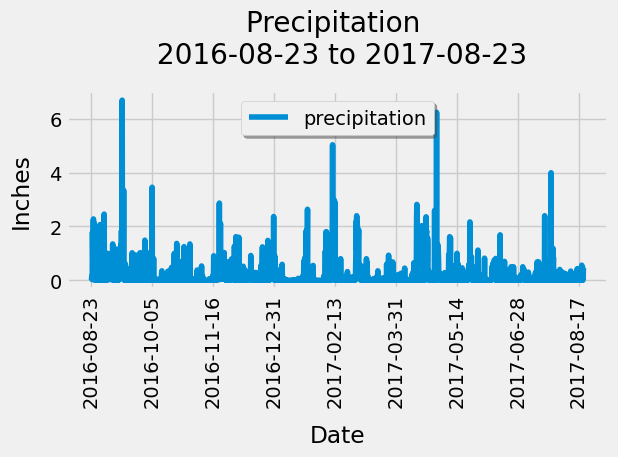

In [28]:
clean_rain_df.plot('date', 'prcp')
font = {'weight': 'bold', 'size': '10'}
# plt.figure(figsize=(15, 10))
plt.style.use('fivethirtyeight')
plt.xlabel("Date", labelpad=12)
plt.ylabel("Inches", labelpad=12)
plt.title(f'Precipitation \n {year_ago} to {current}', pad=20)
plt.legend(["precipitation"],loc='best', shadow=True)
plt.xticks(rotation="vertical")
plt.tight_layout()
plt.savefig("Output/precipitation_12mo.png")
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
clean_rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
station_number = session.query(Station.station).count()
station_number
  

9

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_activity = session.query(func.count(Measure.id), Measure.station).\
    group_by(Measure.station).\
    order_by(func.count(Measure.id).desc()).all()
   
for x in station_activity:
    print(x)

(2772, 'USC00519281')
(2724, 'USC00519397')
(2709, 'USC00513117')
(2669, 'USC00519523')
(2612, 'USC00516128')
(2202, 'USC00514830')
(1979, 'USC00511918')
(1372, 'USC00517948')
(511, 'USC00518838')


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = session.query(Station.name, func.min(Measure.tobs)\
    , func.max(Measure.tobs)\
    , func.round(func.avg(Measure.tobs),2)).\
    filter(Measure.station == Station.station).\
    filter(Measure.station == 'USC00519281').all()

most_active_station

[('WAIHEE 837.5, HI US', 54.0, 85.0, 71.66)]

In [22]:
most_active_station_temp = session.query(Station.name, Measure.date, Measure.tobs).\
    filter(Measure.station == Station.station).\
    filter(Measure.station == 'USC00519281').\
    filter(Measure.date >= year_ago).\
    filter(Measure.date <= current).\
    filter(Measure.tobs != 'None').\
    order_by(Measure.date).all()

# Save query results to a dataframe

df = pd.DataFrame(most_active_station_temp)
df

,name,date,tobs
0,"WAIHEE 837.5, HI US",2016-08-23,77.0
1,"WAIHEE 837.5, HI US",2016-08-24,77.0
2,"WAIHEE 837.5, HI US",2016-08-25,80.0
3,"WAIHEE 837.5, HI US",2016-08-26,80.0
4,"WAIHEE 837.5, HI US",2016-08-27,75.0
...,...,...,...
347,"WAIHEE 837.5, HI US",2017-08-14,77.0
348,"WAIHEE 837.5, HI US",2017-08-15,77.0
349,"WAIHEE 837.5, HI US",2017-08-16,76.0
350,"WAIHEE 837.5, HI US",2017-08-17,76.0


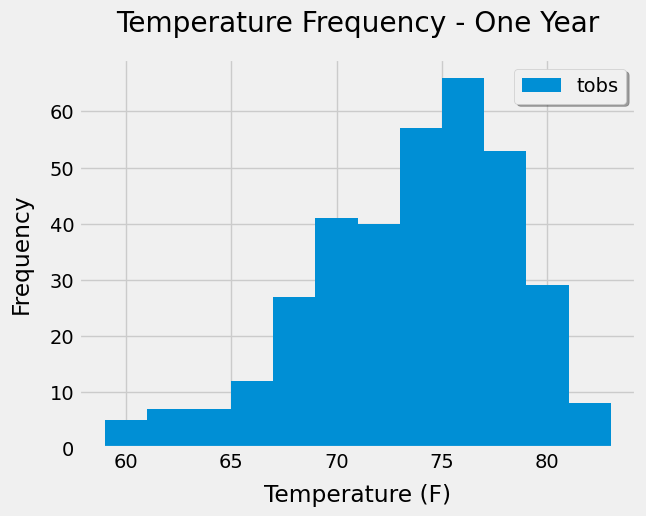

NormaltestResult(statistic=9.287789593975871, pvalue=0.009620156011850603)
NormaltestResult(statistic=17.102417728043683, pvalue=0.00019331127121244702)


In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station_temp = session.query(Measure.date, Measure.tobs).\
    filter(Measure.station == 'USC00519281').\
    filter(Measure.date >= year_ago).\
    filter(Measure.date <= current).\
    order_by(Measure.date).all()

# Save query results to a dataframe

df = pd.DataFrame(most_active_station_temp)

# Plot results as a histogram

import scipy.stats as st
plt.hist(df['tobs'], bins=12)
plt.title('Temperature Frequency - One Year', pad=20)
plt.legend(['tobs'], shadow=True, loc='upper right')
plt.xlabel('Temperature (F)', labelpad=8)
plt.ylabel('Frequency', labelpad=12)
plt.savefig("Output/temp_frequency.png")
plt.show()
print(st.normaltest(df['tobs'].sample(50)))
print(st.normaltest(df['tobs'].sample(300)))



# Close session

In [24]:
# Close Session
session.close()